# #OneSight

In [4]:
%load_ext autoreload
%autoreload 2
import sys
codebase_dir = '/Users/juan/ZiaLab/Codebase'
sys.path.append(codebase_dir)
import wavesight as ws
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.optimize import fsolve, root_scalar
import cmasher as cm
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
%config InlineBackend.figure_format='retina'
import warnings
print("Warning disabling RuntimeWarning often due to evalution of square roots with negative arguments.\nProbably produced by scalar_root.")
warnings.filterwarnings("ignore", category=RuntimeWarning)
import pickle
from matplotlib.patches import Circle
import matplotlib.ticker as ticker
import cmasher as cmr
from matplotlib.patches import Rectangle, Circle
from scipy.interpolate import RegularGridInterpolator


Warning disabling RuntimeWarning often due to evalution of square roots with negative arguments.
Probably produced by scalar_root.


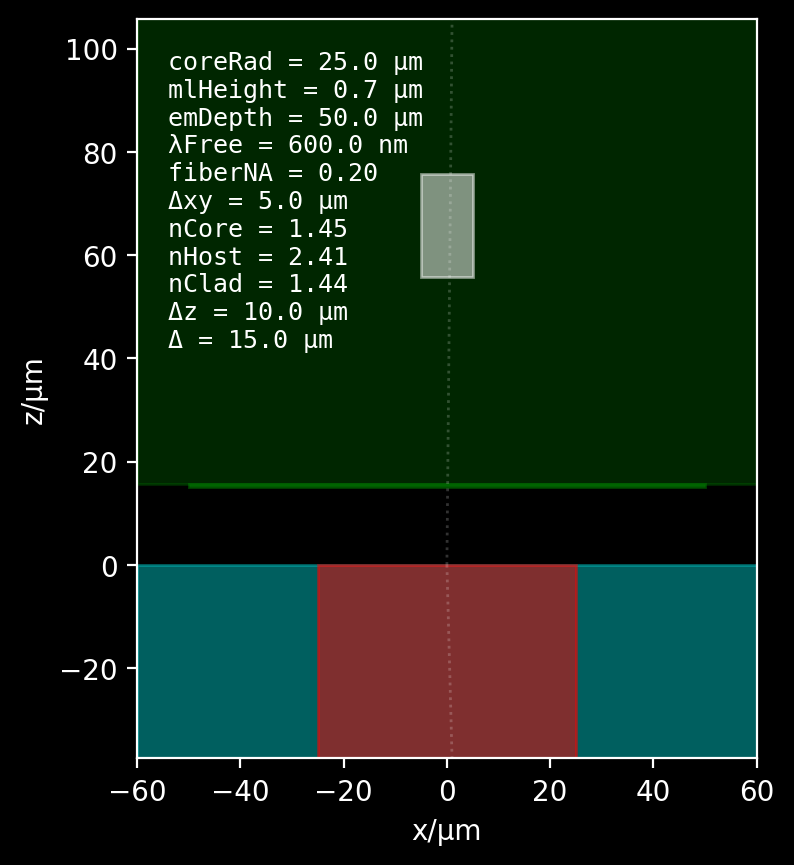

In [5]:
dev_design = {'coreRadius':25., 'mlRadius':50., 'Δ':15., 'mlPitch':0.3,'NA': 0.20,
              'emDepth':50., 'emΔxy':5., 'emΔz':10., 'mlHeight':0.7, 
              'nCore':1.45, 'nHost':2.41, 'nCore':1.45, 'λFree':0.6}
fig, ax = ws.device_layout(dev_design)
fig

In [6]:
fiber_spec = {'NA': 0.22,
              'nCore': 1.45,
              'coreRadius':25.,
              'grid_divider': 2,
              'nFree': 1.,
              'λFree': 0.600}
fiber_sol = ws.multisolver(fiber_spec, solve_modes = 'transverse', drawPlots=False, verbose=True)

Estimating nCladding from nCore and NA ...
Approx number of complex HE modes:  800
Approx number of TE modes:  28
Approx number of TM modes:  28
Approx number of total modes:  1658
Approx Max n for HE modes:  40
Calculating TE(0,n) propagation constants ...
Calculating TM(0,n) propagation constants ...

HE modes = 0
TE modes = 36
TM modes = 36
TOTAL modes = 72
FROM_Vnum = 1658


In [7]:
# kz = fiber_sol['TEkz'][0][0]
# stuff = r'''\begin{align*}
# \nabla^2 \vec{H} + \frac{n^2 \omega^2}{c^2} \vec{H} &= i \omega \epsilon_0 \left(\nabla n^2\right)\!\!\times\!\!\vec{E} \\
# \nabla^2 \vec{E} + \frac{n^2 \omega^2}{c^2} \vec{E} &=  \nabla \left(\frac{1}{n^2}\left(\nabla n^2\right) \cdot \vec{E}\right) \\
# n^2 &= \frac{\epsilon}{\epsilon_0} \\
# \vec{E}_t &= \frac{i}{\zeta^2} \left( k_z \nabla_t E_z - \omega \mu_0 \hat{z} \times \nabla_t H_z \right) \\
# \vec{H}_t &= \frac{i}{\zeta^2} \left( k_z \nabla_t H_z + \omega \epsilon_0 n^2 \hat{z} \times \nabla_t E_z \right) \\
# \zeta^2 &= \frac{n^2\omega^2}{c^2} - k_z^2 \\
# E_z &= A_e J_m(\gamma \rho) e^{i m \phi} \text{ for } \rho < R_\text{core} \\
# E_z &= B_e K_m(\beta \rho) e^{i m \phi} \text{ for } \rho > R_\text{core} \\
# H_z &= A_h J_m(\gamma \rho) e^{i m \phi} \text{ for } \rho < R_\text{core} \\
# H_z &= B_h K_m(\beta \rho) e^{i m \phi} \text{ for } \rho > R_\text{core} \\
# \gamma^2 &= \frac{n_\text{core}^2 \omega^2}{c^2} - k_z^2 \\
# \beta^2 &= k_z^2 - \frac{n_\text{cladd}^2 \omega^2}{c^2} \\
# A_e &= %s \\
# A_h &= %s \\
# B_e &= %s \\
# B_h &= %s \\
# \end{align*}''' % (ws.num2tex(1,2), ws.num2tex(1,2), ws.num2tex(1,2), ws.num2tex(1,2))
# ws.latex_eqn_to_png(stuff,'trial')


## ##FG050LGA

### ###Calculate the numerical mode basis

In [8]:
fiber_sol = ws.calculate_numerical_basis(fiber_sol)

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

In [9]:
# grab the data for the mode of interest
(modtype, m, kzidx, γ, β, Ae, Ah, Be, Bh) = fiber_sol['eigenbasis_nums'][0]
kz = fiber_sol['TEkz'][0][0]

In [10]:
# put everything together
mode_info = r'''\begin{align*}
\nabla^2 \vec{H} + \frac{n^2 \omega^2}{c^2} \vec{H} &= i \omega \epsilon_0 \left(\nabla n^2\right)\!\!\times\!\!\vec{E} \\
\nabla^2 \vec{E} + \frac{n^2 \omega^2}{c^2} \vec{E} &=  \nabla \left(\frac{1}{n^2}\left(\nabla n^2\right) \cdot \vec{E}\right) \\
n^2 &= \frac{\epsilon}{\epsilon_0} \\
\vec{E}_t &= \frac{i}{\zeta^2} \left( k_z \nabla_t E_z - \omega \mu_0 \hat{z} \times \nabla_t H_z \right) \\
\vec{H}_t &= \frac{i}{\zeta^2} \left( k_z \nabla_t H_z + \omega \epsilon_0 n^2 \hat{z} \times \nabla_t E_z \right) \\
\zeta^2 &= \frac{n^2\omega^2}{c^2} - k_z^2 \\
E_z &= A_e J_m(\gamma \rho) e^{i m \phi} \text{ for } \rho < R_\text{core} \\
E_z &= B_e K_m(\beta \rho) e^{i m \phi} \text{ for } \rho > R_\text{core} \\
H_z &= A_h J_m(\gamma \rho) e^{i m \phi} \text{ for } \rho < R_\text{core} \\
H_z &= B_h K_m(\beta \rho) e^{i m \phi} \text{ for } \rho > R_\text{core} \\
\gamma^2 &= \frac{n_\text{core}^2 \omega^2}{c^2} - k_z^2 \\
\beta^2 &= k_z^2 - \frac{n_\text{cladd}^2 \omega^2}{c^2} \\
R_\text{core} &= %s \mu\text{m} \\
n_\text{core} &= %s \\
n_\text{cladd} &= %s \\
m = %d \\
A_e &= %s \\
A_h &= %s \\
B_e &= %s \\
B_h &= %s \\
k_z &= %s\,\mu\text{m}^{-1} \\
\gamma &= %s\,\mu\text{m}^{-1} \\
\beta &= %s\,\mu\text{m}^{-1} \\
\end{align*}''' % (ws.num2tex(fiber_spec['coreRadius'],2),
                   ws.num2tex(fiber_spec['nCore'],3),
                   ws.num2tex(fiber_spec['nCladding'],3),
                   m,
                   ws.num2tex(Ae,2), ws.num2tex(Ah,2), 
                   ws.num2tex(Be,2), ws.num2tex(Bh,2),
                   ws.num2tex(kz,2),
                   ws.num2tex(γ,2), ws.num2tex(β,2))
ws.latex_eqn_to_png(mode_info, 'modeTE00', timed=False)


In [11]:
fiber_sol['coord_layout'] = ws.coordinate_layout(fiber_sol)
a, b, Δs, xrange, yrange, ρrange, φrange, Xg, Yg, ρg, φg, nxy, crossMask, numSamples = fiber_sol['coord_layout']


### ###Plot the mode

In [2]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [264]:
a, b, Δs, xrange, yrange, ρrange, φrange, Xg, Yg, ρg, φg, nxy, crossMask, numSamples = fiber_sol['coord_layout']
nCore = fiber_sol['nCore']
nCladding = fiber_sol['nCladding']
λfree = fiber_sol['λFree']

In [265]:
annotations = []

for modtype in ['TE','TM','HE']:
    solkey = modtype + 'kz'
    for m, kzs in fiber_sol[solkey].items():
        for kzidx, kz in enumerate(kzs):
            γ = np.sqrt(nCore**2*4*np.pi**2/λfree**2 - kz**2)
            β = np.sqrt(kz**2 - nCladding**2*4*np.pi**2/λfree**2)
            annotationTR = '%s(%d,%d)' % (modtype, m, kzidx)
            annotationBR = 'kz=%.3f µm⁻¹' % (kz)
            annotations.append((annotationTR, annotationBR))

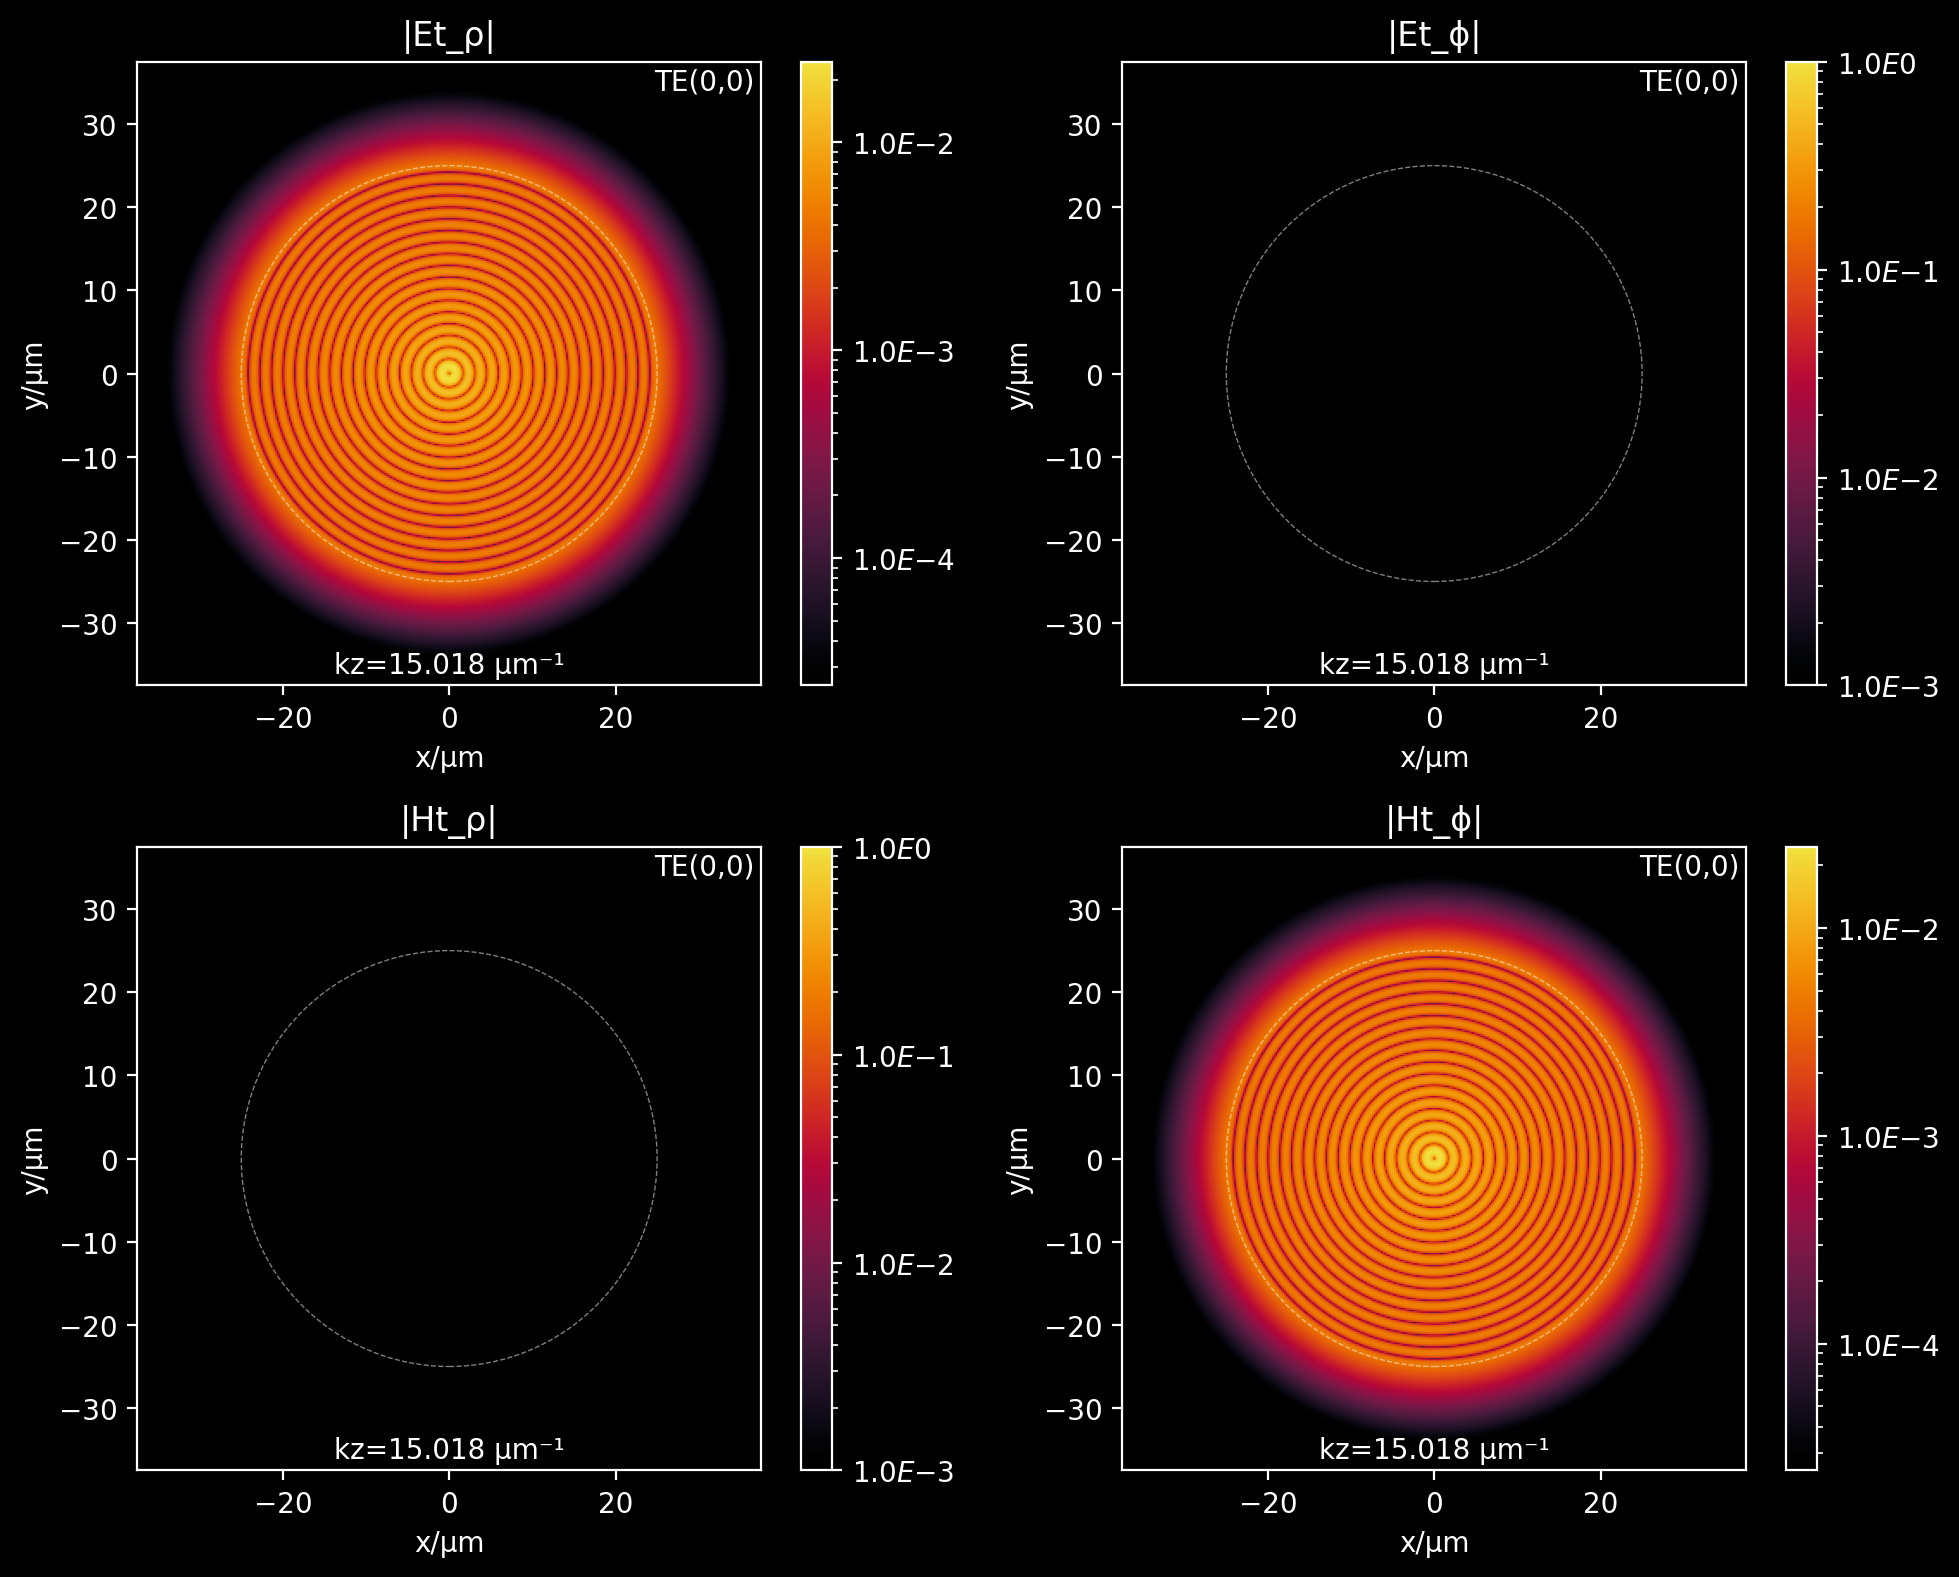

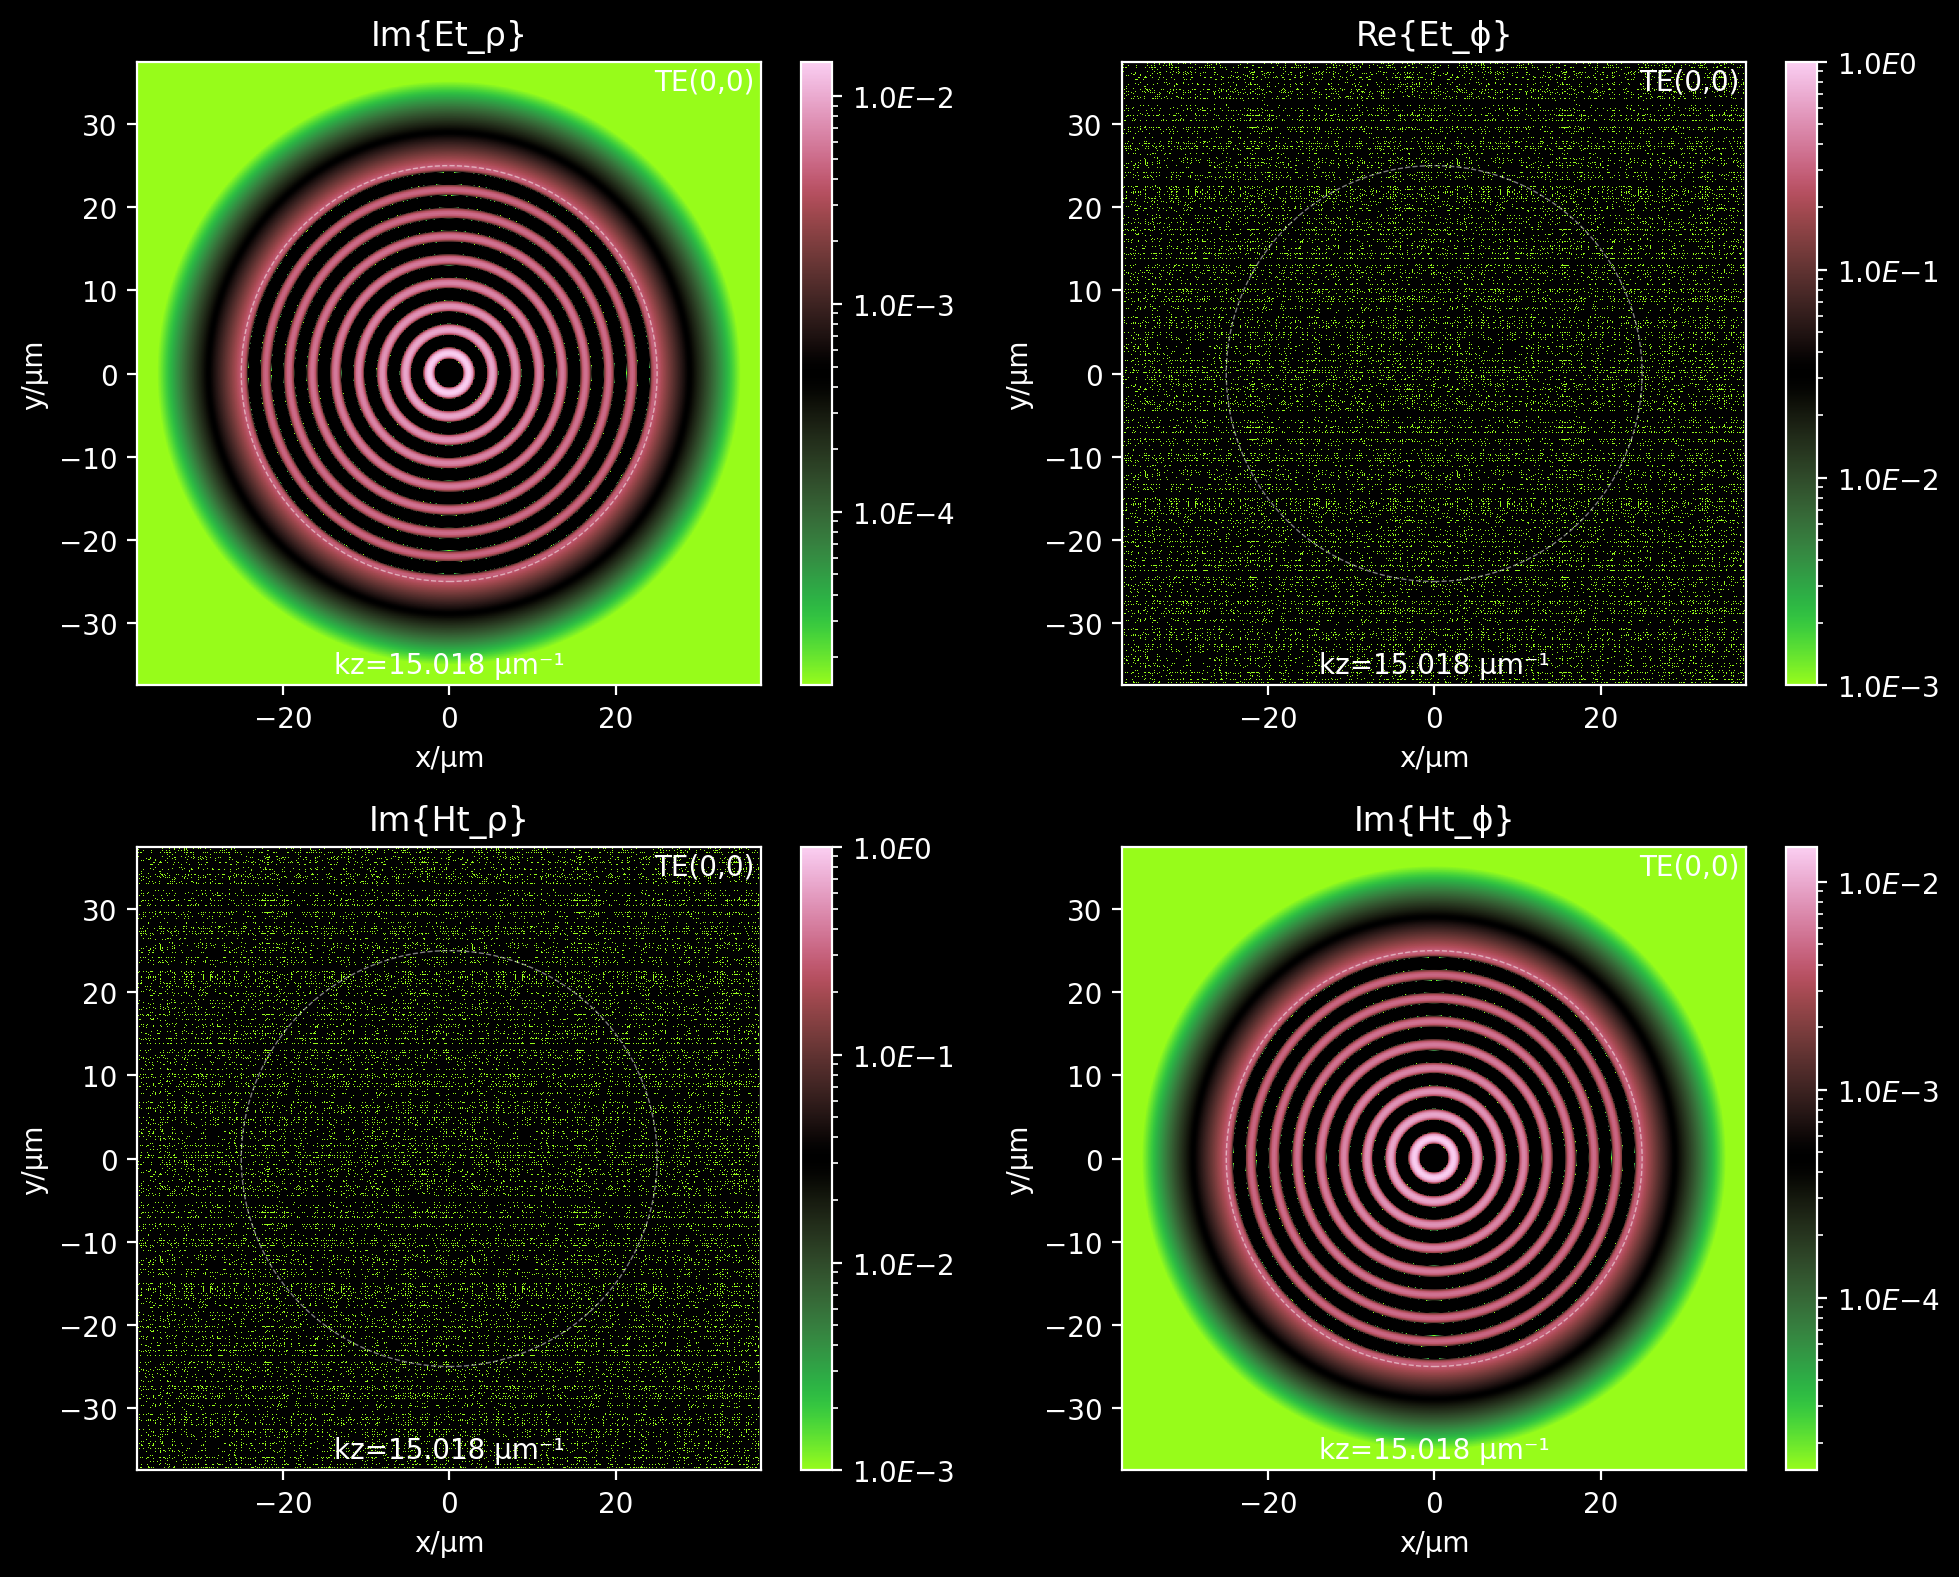

In [266]:
# plot one
def fmt(x, pos):
    if x == 0:
        return '0'
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} E{{{}}}$'.format(a, b)

eigenbasis = fiber_sol['eigenbasis']

plt.style.use('dark_background')
component_index = {"Et_ρ":(0,0), "Et_ϕ":(0,1), "Ht_ρ":(1,0), "Ht_ϕ":(1,1)}
index = 0
extent  = [-b,b,-b,b]
for fun_picker in [np.abs, np.real]:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
    if fun_picker in [np.real, np.imag]:
        cmap = cm.watermelon
        if fun_picker == np.real:
            title_format = 'Re{%s}'
        else:
            title_format = 'Im{%s}'
    else:
        cmap = cm.ember
        title_format = '|%s|'
    for component, ci in component_index.items():
        field   = fiber_sol['eigenbasis'][index, ci[0], ci[1], :, :]
        field   = fun_picker(field)
        if np.max(field) == 0 and fun_picker != np.abs:
            if fun_picker == np.real:
                fun_picker = np.imag
                title_format = 'Im{%s}'
            else:
                fun_picker = np.real
                title_format = 'Re{%s}'
            field   = eigenbasis[index, ci[0], ci[1], :, :]
            field   = fun_picker(field)
        axis = axes[ci[0], ci[1]]
        if fun_picker in [np.real, np.imag]:
            themax = np.max(field)
            if themax == 0:
                themax = 1
            vmax = themax
            vmin = -themax
        else:
            vmax = np.max(field)
            vmin = 0
            if vmax == 0:
                vmax = 1
                vmin = 0
        iplot = axis.imshow(field, 
                # vmin=vmin,
                # vmax=vmax,
                norm=LogNorm(vmin=vmax*1e-3, vmax=vmax),
                extent=extent,
                cmap=cmap)
        axis.set_xlabel('x/µm')
        axis.set_ylabel('y/µm')
        axis.set_title(title_format % component)
        axis.text(0.99, 0.99, annotations[index][0], color='w', transform=axis.transAxes, horizontalalignment='right', verticalalignment='top')
        axis.text(0.5, 0.01, annotations[index][1], color='w', transform=axis.transAxes, horizontalalignment='center', verticalalignment='bottom')
        circle = Circle((0,0), a, linestyle='--', edgecolor='white', facecolor='none', alpha=0.5, linewidth=0.5)
        axis.add_patch(circle)
        divider = make_axes_locatable(axis)
        cax = divider.append_axes("right", size="5%", pad=0.2)
        plt.colorbar(iplot, cax=cax, format=ticker.FuncFormatter(fmt))
    plt.tight_layout()
    plt.show()

### ###Launching fields across the end of the waveguide

In [12]:
totalModes = fiber_sol['totalModes']
λfree = fiber_sol['λFree']
eigenbasis = fiber_sol['eigenbasis']
nCore = fiber_sol['nCore']
nCladding = fiber_sol['nCladding']
a, b, Δs, xrange, yrange, ρrange, φrange, Xg, Yg, ρg, φg, nxy, crossMask, numSamples = fiber_sol['coord_layout']

In [13]:
annotations = []

for modtype in ['TE','TM','HE']:
    solkey = modtype + 'kz'
    for m, kzs in fiber_sol[solkey].items():
        for kzidx, kz in enumerate(kzs):
            γ = np.sqrt(nCore**2*4*np.pi**2/λfree**2 - kz**2)
            β = np.sqrt(kz**2 - nCladding**2*4*np.pi**2/λfree**2)
            annotationTR = '%s(%d,%d)' % (modtype, m, kzidx)
            annotationBR = 'kz=%.3f µm⁻¹' % (kz)
            annotations.append((annotationTR, annotationBR))

In [14]:
index = 0
nFree = 1.0
annot = annotations[index]
# pick the E and H fields
Einc = eigenbasis[index, 0, :, :, :]
Hinc = np.conjugate(eigenbasis[index, 1, :, :, :])
kref, Eref, Href = ws.poyntingrefractor(Einc, Hinc, nFree, nxy, verbose=True)

Calculating the Poynting vector field...
Calculating the magnitude of the Poynting field...
Calculating the transverse component of the Poynting field...
Calculating the unit vector in the direction of the Poynting vector...
Calculating the angle of incidence field...
Calculating the angle of refraction field...
Calculating the Fresnel coefficients...
Calculating the ζ of the local coord system...
Calculating the S and P component of the incident electric field...
Calculating the S and P component of the refracted electric field...
Calculating the total refracted electric field...
Calculating the refracted wavevector (normalized) field...
Calculating the refracted H field...


### ###Convert cylindrical anchored to cartesian into cartesian anchored to cartesian

In [271]:
a, b, Δs, xrange, yrange, ρrange, φrange, Xg, Yg, ρg, φg, nxy, crossMask, numSamples = fiber_sol['coord_layout']

In [272]:
Erefcc = ws.from_cyl_cart_to_cart_cart(Eref)
Hrefcc = ws.from_cyl_cart_to_cart_cart(Href)

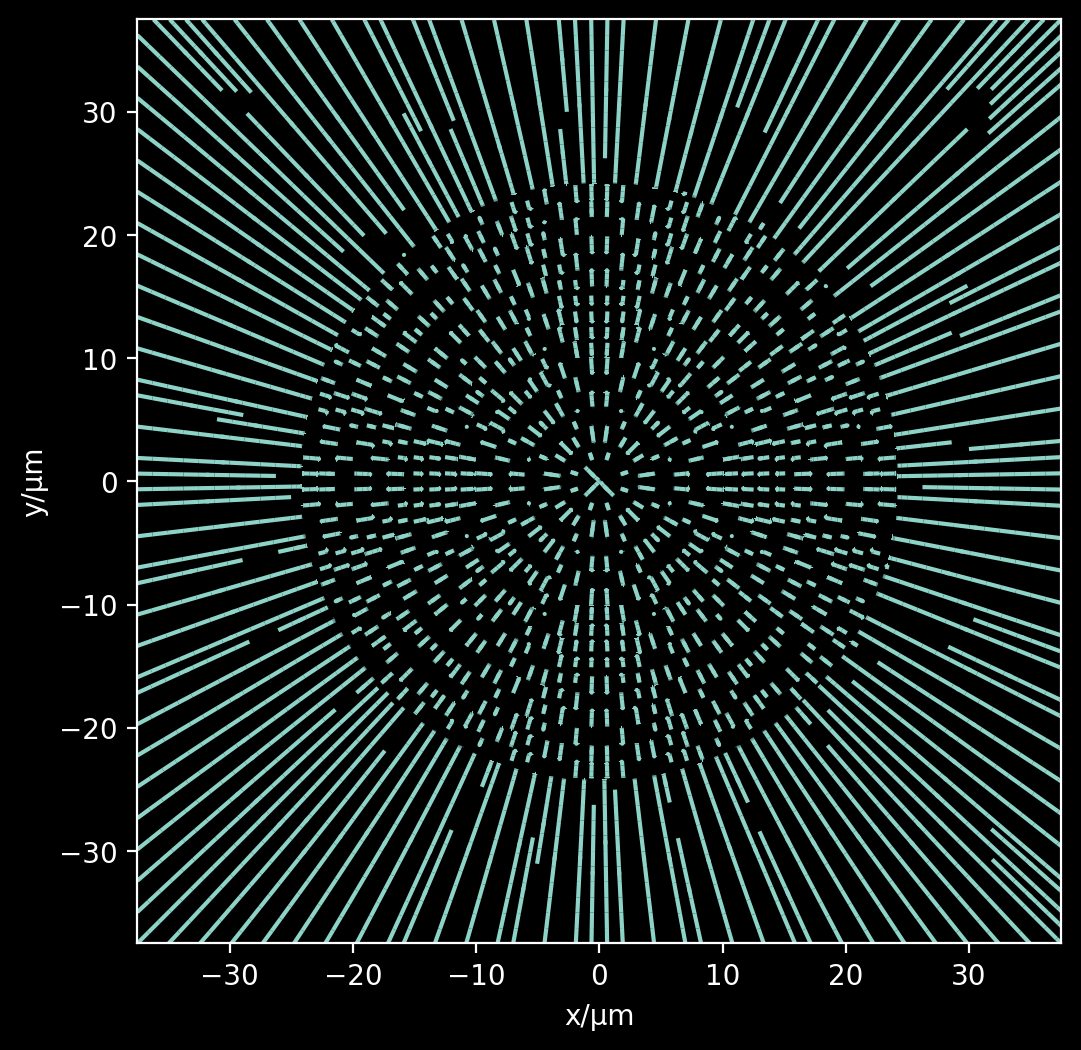

In [273]:
# this might take about a minute or so
fig, ax = plt.subplots(figsize=(6,6))
ax.streamplot(Xg, Yg, 
              np.imag(ccfield[0]), 
              np.imag(ccfield[1]), arrowstyle='-', density=2)
ax.set_xlabel('x/µm')
ax.set_ylabel('y/µm')
ax.set_aspect('equal')
plt.show()

In [274]:
ErefFuns = []
HrefFuns = []
for field_idx in [0,1]:
    refField = [Erefcc, Hrefcc][field_idx]
    for idx in [0,1,2]:
        theFieldComponent = refField[idx]
        fieldInterpol = RegularGridInterpolator((xrange, yrange), 
                        theFieldComponent,
                        method='linear', 
                        bounds_error=False, 
                        fill_value=0)
        if field_idx == 0:
            ErefFuns.append(fieldInterpol)
        else:
            HrefFuns.append(fieldInterpol)

In [275]:
(numSamples, xCoords, yCoords, E3) = ws.vectorfieldprop(2*b, 10., ErefFuns, 0.6, 1.0, numSamples=len(xrange), interpFun=True)
(numSamples, xCoords, yCoords, H3) = ws.vectorfieldprop(2*b, 10., HrefFuns, 0.6, 1.0, numSamples=len(xrange), interpFun=True)

AttributeError: module 'wavesight' has no attribute 'vectorfieldprop'

In [ ]:
λFree = 0.6
nHost = 1.5
λHost = λFree / nHost
Rmax = 20 # arbitrary
Δ = dev_design['Δ']
def fresnel_profile(f):
    phase_fun = lambda x,y: (np.sqrt(x**2+y**2 + f**2)-f)
    return phase_fun

In [ ]:
fp = fresnel_profile(Δ)

In [ ]:
phase_map = -2*np.pi/λHost * fp(Xg,Yg)
complex_phase_map = np.exp(1j * phase_map)
complex_phase_map[Xg**2 + Yg**2 > Rmax**2] = 0

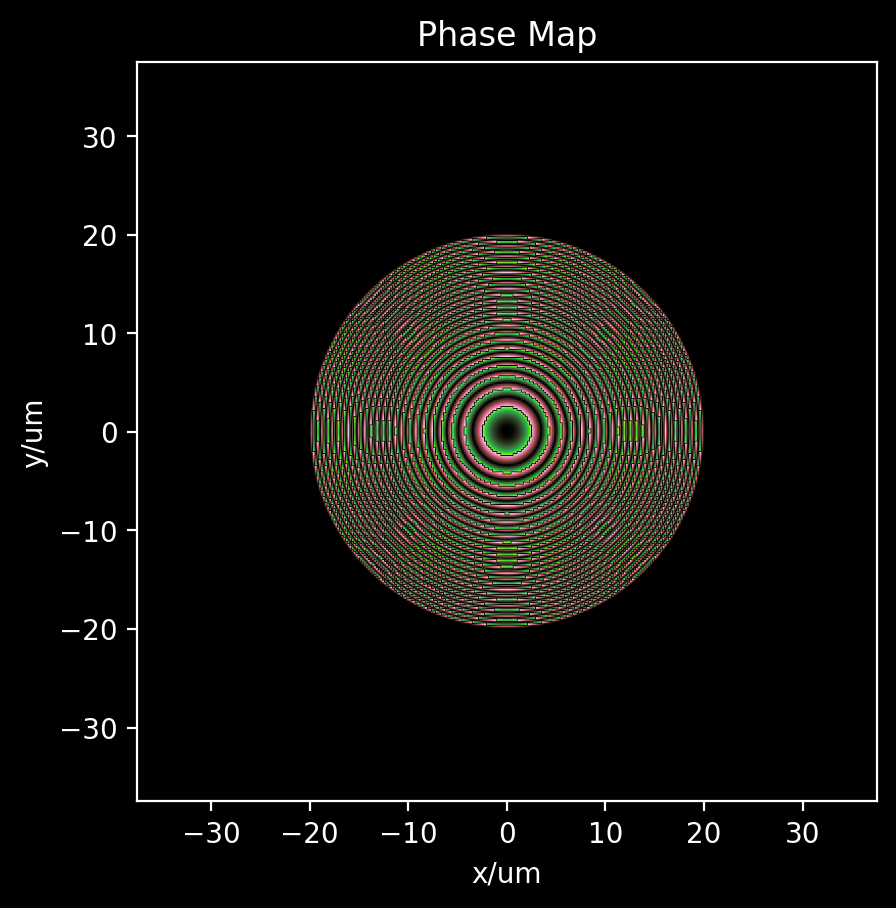

In [ ]:
fig, ax = plt.subplots()
ax.imshow(np.angle(complex_phase_map), 
        extent=extent,
        cmap=cm.watermelon)
ax.set_xlabel('x/um')
ax.set_ylabel('y/um')
plt.colorbar()
ax.set_title('Phase Map')
plt.show()

In [ ]:
E4 = E3 * complex_phase_map
H4 = H3 * complex_phase_map

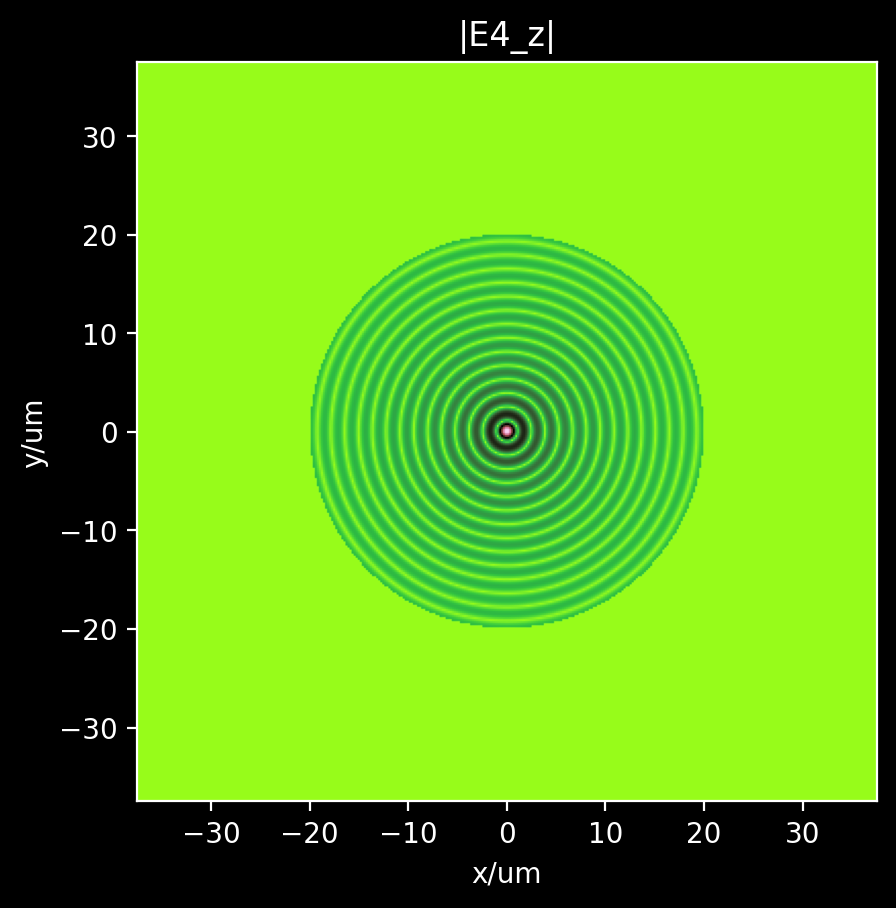

In [ ]:
fig, ax = plt.subplots()
ax.imshow(np.abs(E4[2]), 
        extent=extent,
        cmap=cm.watermelon)
ax.set_xlabel('x/um')
ax.set_ylabel('y/um')
ax.set_title('|E4_z|')
plt.show()

In [ ]:
dev_design = {'coreRadius':25., 'mlRadius':50., 'Δ':15., 'mlPitch':0.3,'NA': 0.20,
              'emDepth':50., 'emΔxy':5., 'emΔz':10., 'mlHeight':0.7, 
              'nCore':1.45, 'nHost':2.41, 'nCore':1.45, 'λFree':0.6}

In [ ]:
dl = xrange[1]-xrange[0]
emΔz = dev_design['emΔz']
emDepth = dev_design['emDepth']
zrange = np.linspace(emDepth-emΔz, emDepth+emΔz, int(2*emΔz/dl))

In [ ]:
E5 = np.zeros((*E4.shape, len(zrange)))
H5 = np.zeros((*H4.shape, len(zrange)))

In [276]:
E4Funs = []
H4Funs = []
for field_idx in [0,1]:
    refField = [E4, H4][field_idx]
    for idx in [0,1,2]:
        theFieldComponent = refField[idx]
        fieldInterpol = RegularGridInterpolator((xrange, yrange), 
                        theFieldComponent,
                        method='linear', 
                        bounds_error=False, 
                        fill_value=0)
        if field_idx == 0:
            E4Funs.append(fieldInterpol)
        else:
            H4Funs.append(fieldInterpol)

In [278]:
for field_index in [0,1]:
    if field_index == 0:
        fieldFuns = E4Funs
    else:
        fieldFuns = H4Funs
    for z_index, z in enumerate(zrange):
        (numSamples, xCoords, yCoords, fields) = ws.vector_field_FFT_RS_prop_func(2*b, z, fieldFuns, 0.6, nHost, numSamples=len(xrange), interpFun=True)
        if field_index == 0:
            E5[:, :, :, z_index] = fields
        else:
            H5[:, :, :, z_index] = fields

In [279]:
slice = E5[:, 181, :, :]
slice = np.sum(np.abs(slice)**2, axis=0)

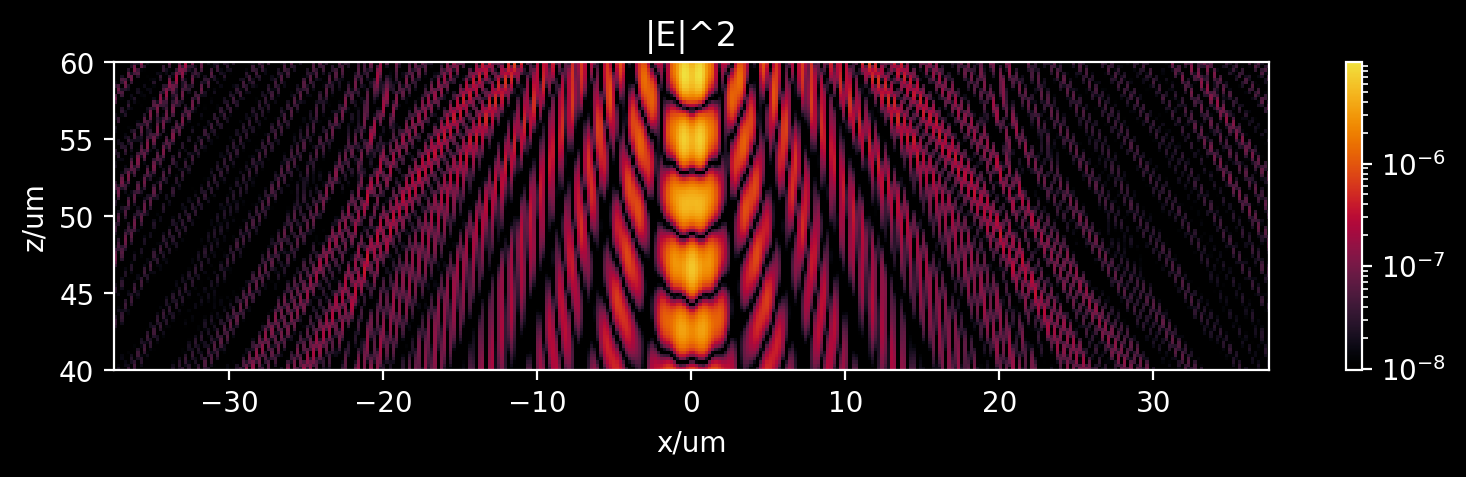

In [281]:
vmax = np.max(slice)
plt.figure(figsize=(10,2))
plt.imshow(slice.T,
    extent=[-b,b,zrange[0],zrange[-1]],
    cmap=cmr.ember,
    norm=LogNorm(vmin=vmax*1e-3, vmax=vmax),
    )
plt.xlabel('x/um')
plt.ylabel('z/um')
plt.title('|E|^2')
#plt.xlim(-10,10)
plt.colorbar()
plt.show()

In [251]:
mlHeight = dev_design['mlHeight']

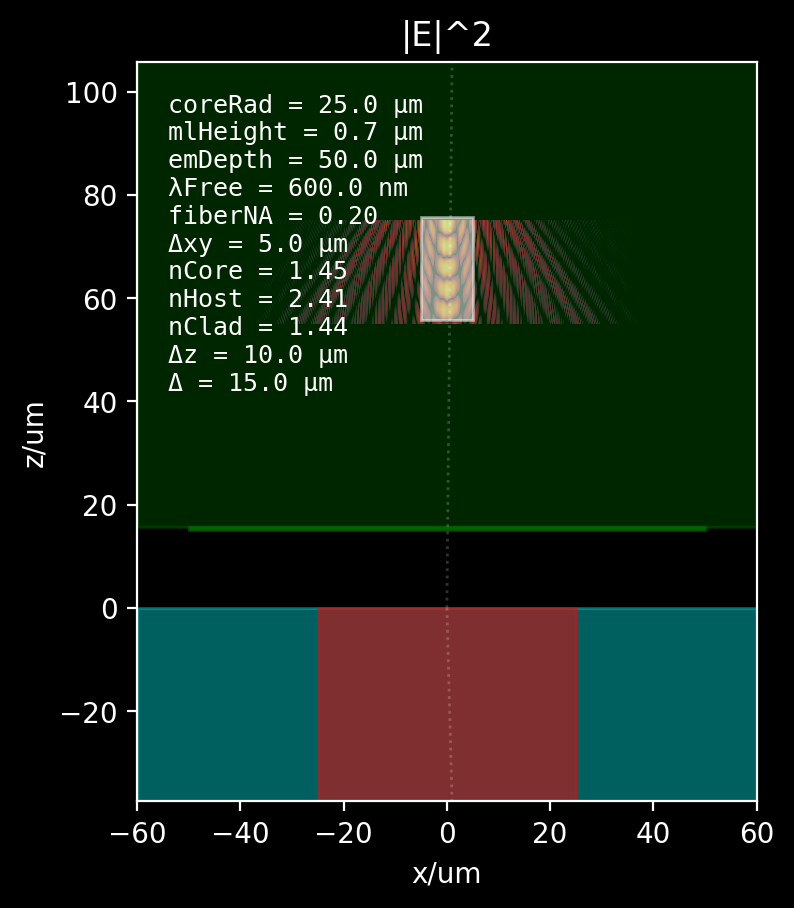

In [254]:
dev_design = {'coreRadius':25., 'mlRadius':50., 'Δ':15., 'mlPitch':0.3,'NA': 0.20,
              'emDepth':50., 'emΔxy':5., 'emΔz':10., 'mlHeight':0.7, 
              'nCore':1.45, 'nHost':2.41, 'nCore':1.45, 'λFree':0.6}
fig, ax = ws.device_layout(dev_design)
vmax = np.max(slice)
ax.imshow(slice.T,
        extent=[-b,b,zrange[0]+Δ,zrange[-1]+Δ],
        cmap=cmr.ember,
        norm=LogNorm(vmin=vmax*1e-3, vmax=vmax),
        )
ax.set_xlabel('x/um')
ax.set_ylabel('z/um')
ax.set_title('|E|^2')
fig